# Examples:
Let's look at some of the most commonly used things this library can do to collect and post-process IQ data from an RTL-SDR.

In [1]:
from rtlobs import collect as col
from rtlobs import post_process as post

We can find the total power incident on the SDR by integrating the complex samples at a certain frequency for an amount of time:

In [2]:
# 1024 complex samples per call to the SDR
# 49.6 dB of RtlSdr gain
# 2.048 MHz sample rate/bandwidth
# 91.3 MHz center frequency
# 5 sec integration time
p_tot = col.run_total_power_int(1024, 49.6, 2.048e6, 91.3e6, 5)
print('Uncalibrated total power measurement: {}'.format(p_tot))

Initializing rtl-sdr with pyrtlsdr:
  sample rate: 2.048 MHz
  center frequency 91.3 MHz
  gain: 49.6 dB
  num samples per call: 1024
  requested integration time: 5s
  => num samples to collect: 10240000
  => est. num of calls: 10000
Integration began at Wed, 19 Feb 2020 20:37:26
Integration ended at Wed, 19 Feb 2020 20:37:31 after 5.005967378616333 seconds.
10000 calls were made to SDR.
10240000 samples were measured at 91.3 MHz
for an effective integration time of 5.00s
Uncalibrated total power measurement: 0.01647084704200312


We can estimate the power spectral density recorded by the SDR for a given bandwidth by averaging multiple spectra over time to reduce the noise:

Initializing rtl-sdr with pyrtlsdr:
  sample rate: 2.320000 MHz
  center frequency 1420.000000 MHz
  gain: 49 dB
  num samples per call: 8192
  PSD binning: 2048 bins
  requested integration time: 10s
  => num samples to collect: 23200000
  => est. num of calls: 2832
Integration began at Wed, 19 Feb 2020 20:37:32
Integration ended at Wed, 19 Feb 2020 20:38:06 after 34.348241090774536 seconds.
2832 spectra were measured at 1420000000.0.
for an effective integration time of 10.00s


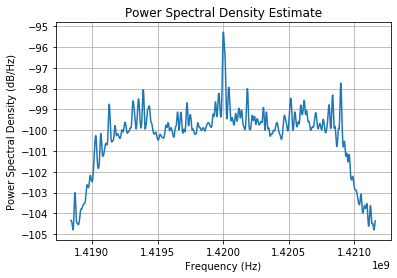

In [3]:
from rtlobs import collect as col
from rtlobs import post_process as post
# 8192 samples per call to the SDR
# 2048 bin resolution power spectral density estimate
# 49.6 dB of RtlSdr gain
# 2.32 MHz sample rate/bandwidth
# 1.420 GHz center frequency
# 10 sec integration time
f, p = col.run_spectrum_int(8192, 2048, 49.6, 2.32e6, 1.420e9, 10)
# Show the figure containing the plotted spectrum
fig, ax = post.plot_spectrum(f, p, savefig='../images/spectrum_int.png')

And we can even run in frequency-switching mode, periodically retuning the SDR between two frequencies to reduce baseline bandpass shape and increase signal-to-noise on a spectral line!

Note that the folding process performed on frequency-switched data happens in terms of the absolute values (power) rather than relative values (dB), so we make those changes to the plot labels.

Initializing rtl-sdr with pyrtlsdr:
  sample rate: 2.048000 MHz
  center frequency 88.950000 MHz
  gain: 49 dB
  num samples per call: 8192
  requested integration time: 5.0s
  => num samples to collect: 10240000
  => est. num of calls: 1250
  => num samples on each dwell: 409600
  => est. num of calls on each dwell: 50
  => num dwells total: 25
Integration began at Wed, 19 Feb 2020 20:38:07
Integration ended at Wed, 19 Feb 2020 20:38:15 after 7.555290222167969 seconds.
1250 spectra were measured, split between 88950000.0 and 89250000.0.
for an effective integration time of 5.00s


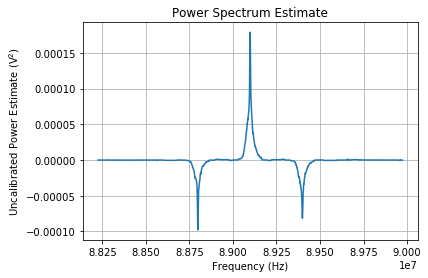

In [4]:
f, p = col.run_fswitch_int(8192, 2048, 49.6, 2.048e6, 88.95e6, 89.25e6, 5.0, fswitch=5)
fig, ax = post.plot_spectrum(f, p)
# Edit figure labels to be technically correct
ax.set_ylabel('Uncalibrated Power Estimate (V$^2$)')
ax.set_title('Power Spectrum Estimate')
fig.savefig('../images/fswitch_int.png')